In [ ]:
import pandas as pd
import requests
import json 
import numpy as np
import matplotlib.pyplot as pl

In [ ]:
import os
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, Point

In [ ]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA


In [ ]:
threshold = 95
data_location = '../../new_data/threshold_{}percentile/ca_data_version_6.csv'.format(threshold)

In [ ]:
solar = pd.read_csv(data_location)
# solar.drop(columns='Unnamed: 0', index=1, inplace = True)

In [ ]:
solar

In [ ]:
solar[solar['Solar_farm_present']==1]['land_cover'].values

In [ ]:
solar.columns


In [ ]:
solar.describe()

In [ ]:
solar.head()

In [ ]:
solar = solar[solar['min_distance'].notnull()]
solar.describe()

In [ ]:
solar = solar[solar['Solar_farm_present'].notnull()]

In [ ]:
solar.describe()

In [ ]:
solar_existing = solar[solar['Solar_farm_present']==1]
solar_non_existing = solar[solar['Solar_farm_present']==0]
solar_non_existing_sample = solar_non_existing.sample(500, random_state = 42)
solar = pd.concat([solar_existing, solar_non_existing_sample])
solar.describe()

In [ ]:
req_col = ['land_cover','slope', 'elevation',  'solrad_annual','ac_annual', 'min_distance']
X = solar[req_col]
Y = solar['Solar_farm_present']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

sd = StandardScaler()
columns_ML_excluding_LC = ['slope', 'elevation',  'solrad_annual','ac_annual', 'min_distance']
X_train_excluding_LC = X_train[columns_ML_excluding_LC ]
temp = np.hstack((sd.fit_transform(X_train_excluding_LC),X_train['land_cover'].values.reshape((-1,1))))
X_train_2 = pd.DataFrame(temp, columns = columns_ML_excluding_LC + ['land_cover'])

X_test_excluding_LC = X_test[columns_ML_excluding_LC ]
temp = np.hstack((sd.transform(X_test_excluding_LC),X_test['land_cover'].values.reshape((-1,1))))
X_test_2 = pd.DataFrame(temp, columns = columns_ML_excluding_LC+['land_cover'])


assert np.sum(np.abs(X_test_2['land_cover'].values - X_test['land_cover'].values)) == 0
assert np.sum(np.abs(X_train_2['land_cover'].values - X_train['land_cover'].values)) == 0

X_test = X_test_2
X_train = X_train_2

col_index = {'slope':0, 'elevation':1,  'solrad_annual':2,'ac_annual':3, 'min_distance':4,'land_cover':5}
index_col = {0:'slope', 1:'elevation',  2:'solrad_annual',3:'ac_annual', 4:'min_distance',5:'land_cover'}

In [ ]:
len(X_train),len(X_test)

In [ ]:
svm = SVC(kernel='rbf', gamma=0.1, C=1.0, random_state= 113)

params = {"C":(0.1, 1, 2,4),  
          "kernel":('linear', 'rbf','poly')}

svm_cv = GridSearchCV(svm, params, scoring="accuracy", n_jobs=-1, verbose=2, cv=5)
svm_cv.fit(X_train, y_train)

In [ ]:
svm_cv.best_params_

In [ ]:
# svm_tuned = SVC(**svm_cv.best_params_, random_state=113)
svm_tuned = SVC(C=4,kernel='rbf',random_state=113)
pca = PCA(n_components=6)

Xreduced = pca.fit_transform(X_train)
# Xreduced = np.vstack([X_train['ac_annual'].values, X_train['solrad_annual'].values]).T
print(Xreduced.shape,y_train.shape)

svm_tuned.fit(Xreduced, y_train)
y_pred_train_svm = svm_tuned.predict(Xreduced) 
Xreducedtest = pca.transform(X_test)
# Xreducedtest = np.vstack([X_test['ac_annual'].values, X_test['solrad_annual'].values]).T

y_pred_test_svm = svm_tuned.predict(Xreducedtest)

[0.1894152  0.46534452 0.56436825 0.58545286 0.25867676 0.18111   ] [0.1894152  0.46534452 0.56436825 0.58545286 0.25867676 0.13926993] 2.3673203324495815
[ 0.42256854  0.42453365 -0.39753816 -0.34966757  0.60014297 -0.04040139] [ 0.42256854  0.42453365 -0.39753816 -0.34966757  0.60014297 -0.02704499] 1.4400893612934966
[ 0.86410396 -0.14498632  0.0459842  -0.00749583 -0.47788059  0.07652576] [ 0.86410396 -0.14498632  0.0459842  -0.00749583 -0.47788059  0.04198465] 0.864462777312106
[ 0.19168326 -0.75436258  0.18226372  0.11844854  0.58551338 -0.18772732] [ 0.19168326 -0.75436258  0.18226372  0.11844854  0.58551338 -0.06417626] 0.3694196297095739
[ 0.04254719  0.08695488 -0.0214415   0.1878255  -0.04023582 -9.00768597] [ 0.04254719  0.08695488 -0.0214415   0.1878255  -0.04023582 -0.97635624] 0.0864595404076954
[-0.01814709  0.0747032   0.69832481 -0.69685929  0.01000275 -9.14735696] [-0.01814709  0.0747032   0.69832481 -0.69685929  0.01000275 -0.1439432 ] 0.01137040738091612

 Varaianc

[]

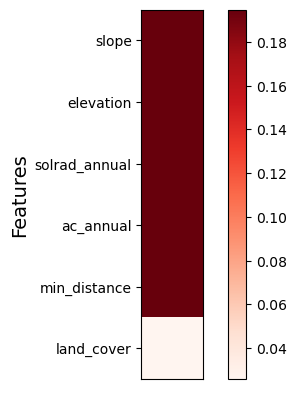

In [975]:
components = pca.components_ #eigenvectors of pca
num_com = components.shape[0]
eigvals = pca.explained_variance_ #eigenvalues of pca
covariance = np.dot(X_train.T,X_train)/(X_train.shape[0]-1)

# checking the SVD decompostion
for i in range(components.shape[0]):
    temp = np.dot(covariance,components[i])/eigvals[i]
    print(temp,components[i],eigvals[i])
    # assert np.mean(np.abs(temp-components[i])) < 1e-8
    # eigvals.append(np.dot(temp,components[i]))

var_ratio = pca.explained_variance_ratio_
var = pca.explained_variance_
print("\n Varaiance covered as we increasing the number of PCA components: ", np.cumsum(var_ratio))

print(np.sum(components[:,0]**2*var_ratio),components[:,0],var_ratio)
fig,ax = pl.subplots()
weighted_contri = np.abs(components[:,:])**2*var_ratio.reshape((num_com,1))
weighted_sum = np.sum(weighted_contri,axis=0).reshape((weighted_contri.shape[1],1))
print(weighted_sum,np.sum(weighted_sum))
xdata = weighted_sum
img = ax.imshow(xdata,cmap='Reds')
pl.colorbar(img)
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels([index_col[i] for i in range(components.shape[1])],fontsize=10)
ax.set_ylabel('Features',fontsize=14)

# ax.set_xticks([0,1,2,3,4,5])
ax.set_xticks([])
# ax.set_xticklabels([i+1 for i in [0,1,2,3,4,5]],fontsize=10)
# ax.set_xlabel('PCA compenents',fontsize=14)
# _ = ax.set_title('Weights of components on features \n (multiplied by the variance ratio of the components)',fontsize=10)

how much variance in PCA? Weights in different features using PCA.
Conclusion:
Decision boundaries, non-trivial points, key take away points, future improvements.

In [ ]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_svm, output_dict=True))
fig, ax = pl.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
pl.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

In [ ]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_svm, output_dict=True))
fig, ax = pl.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
pl.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

## Predicting on new solar farms

In [ ]:
file_loc = 'new_farms.csv'
new_data = pd.read_csv(file_loc)
new_data = new_data.loc[new_data['Solar_farm_present']==1]
print(new_data.columns)

In [ ]:
new_farms = new_data[columns_ML_excluding_LC+['land_cover']]

In [ ]:
sd.transform(new_farms[columns_ML_excluding_LC])

In [ ]:
temp = np.hstack((sd.transform(new_farms[columns_ML_excluding_LC]),new_farms['land_cover'].values.reshape((-1,1))))
new_farms = pd.DataFrame(temp, columns = columns_ML_excluding_LC+['land_cover'])
new_farms_reduced = pca.transform(new_farms)
# Xreducedtest = np.vstack([X_test['ac_annual'].values, X_test['solrad_annual'].values]).T

new_y_pred_test_svm = svm_tuned.predict(new_farms_reduced)

In [ ]:
new_y_pred_test_svm

In [ ]:
df = pd.DataFrame(classification_report([1]*len(new_y_pred_test_svm), new_y_pred_test_svm, output_dict=True))
fig, ax = pl.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
pl.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

## Decision boundary

In [976]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [988]:
sd.var_

array([4.33747858e+01, 3.73230175e+05, 2.82138881e-01, 2.01669464e+10,
       1.48580537e+04])

In [989]:
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_train)
Xreduced = np.vstack([X_train['ac_annual'].values, X_train['min_distance'].values]).T

means = sd.mean_[col_index['ac_annual']],sd.mean_[col_index['min_distance']]
stds = sd.var_[col_index['ac_annual']]**0.5,sd.var_[col_index['min_distance']]**0.5
X0, X1 = Xreduced[:,0]*stds[0]+means[0], Xreduced[:,1]*stds[1]+means[1]
xx, yy = make_meshgrid(X0, X1)

model = SVC(kernel='rbf',C=4)
clf = model.fit(Xreduced, y_train)

farms_reduced = np.vstack([new_farms['ac_annual'].values,new_farms['min_distance']]).T

# farms_reduced = pca.transform(new_farms)
print(farms_reduced.shape,Xreduced.shape)
new_y_pred_test_svm = model.predict(farms_reduced)

fig, ax = pl.subplots()
plot_contours(ax, clf, xx, yy, cmap=pl.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train, cmap=pl.cm.coolwarm, s=20, edgecolors='k')

print(new_farms_reduced[:,col_index['ac_annual']].shape)

# ax.scatter(new_farms_reduced[:,col_index['ac_annual']],new_farms_reduced[:,col_index['elevation']], c=new_y_pred_test_svm, cmap=pl.cm.coolwarm, s=20, edgecolors='k',marker='s')

: 

: 

In [ ]:
Xreduced

In [ ]:
print(np.sum(np.abs(y_pred_train_svm - y_train.values))/len(y_train))
# thresholds
solar_slopes = solar.loc[solar['Solar_farm_present']==1]['slope'].values.copy()
solor_elevations = solar.loc[solar['Solar_farm_present']==1]['elevation'].values.copy()
solar_distance = solar.loc[solar['Solar_farm_present']==1]['min_distance'].values.copy()
solar_ac_annual = solar.loc[solar['Solar_farm_present']==1]['ac_annual'].values.copy()

slope_threshold = np.percentile(solar_slopes,threshold)
elevations_threshold = np.percentile(solor_elevations,threshold)
distance_threshold = np.percentile(solar_distance,threshold)
ac_threshold = np.percentile(solar_ac_annual,threshold)
print('slope_th:{}, elevation_th:{}, distance_th:{}, ac_th:{}'.format(slope_threshold,elevations_threshold,distance_threshold,ac_threshold))

print(np.sum(np.abs(y_pred_test_svm - y_test.values))/len(y_test))

In [ ]:
X_train

In [ ]:
fake_data = 